# Packages

In [6]:
import pandas as pd
import polars as pl
import polars.selectors as cs
import numpy as np
import plotnine as pn
import matplotlib.pyplot as plt
from mizani.formatters import comma_format, custom_format, currency_format, percent_format
from IPython.display import clear_output, display
import os
import glob
from tqdm.notebook import tqdm
import itertools
import yaml
import matplotlib.font_manager as fm
import matplotlib as mpl
from matplotlib import rc

rc('text', usetex=False)

jama_colour = [
    "#374e55",
    "#df8f44",
    "#00a1d5",
    "#b24745",
    "#79af97",
    "#6a6599",
    "#80796b",
]

pd.set_option("display.max.columns", 500)
pd.set_option("display.max.columns", 500)


theme_academic = pn.theme(
    text=pn.element_text(family="Latin Modern Roman"),
    plot_title=pn.element_text(weight="bold", size=14, ha="center"),
    legend_text=pn.element_text(size=9),  # Smaller font for legend items
    panel_background=pn.element_rect(fill="white"),  # Clean white background
    panel_border=pn.element_rect(color="grey", size=0.5),
    axis_ticks=pn.element_line(color="grey"),
    panel_grid_major=pn.element_line(color="grey", size=0.1, alpha=0.3),
    panel_grid_minor=pn.element_line(color="grey", size=0.1, alpha=0.3),
    legend_background=pn.element_rect(fill="white", color=None),
    legend_key=pn.element_rect(fill="white", color=None),
    plot_margin=0.02,
    figure_size=(6, 4),  # Set default figure size (width, height in inches)
)

%matplotlib inline

# Read Holdout Predictions

In [7]:
prediction_paths = [path for path in os.listdir() if "holdout_predictions" in path]
prediction_paths

['3_SARIMAX_holdout_predictions_no_retraining.csv',
 '4_NBEATSX_holdout_predictions_no_retraining.csv',
 '4_NBEATSX_holdout_predictions_with_retraining.csv',
 '5_RIDGE_holdout_predictions.csv',
 '5_RIDGE_holdout_predictions_no_retraining.csv',
 '5_RIDGE_holdout_predictions_with_retraining.csv',
 '6_NAIVE_holdout_predictions.csv',
 '7_ANN_holdout_predictions_no_retraining.csv',
 '7_ANN_holdout_predictions_with_retraining.csv',
 '8_LGBM_holdout_predictions_no_retraining.csv',
 '8_LGBM_holdout_predictions_with_retraining.csv']

In [8]:
results = (
    pd.concat(
        [
            # SARIMAX
            pd.read_csv("3_SARIMAX_holdout_predictions_no_retraining.csv").assign(
                model="SARIMAX", retraining="no"
            ),
            # NBEATSx
            pd.read_csv("4_NBEATSX_holdout_predictions_no_retraining.csv").assign(
                model="NBEATSx", retraining="no"
            ),
            pd.read_csv("4_NBEATSX_holdout_predictions_with_retraining.csv").assign(
                model="NBEATSx", retraining="yes"
            ),
            # RIDGE
            pd.read_csv("5_RIDGE_holdout_predictions_no_retraining.csv").assign(
                model="RIDGE", retraining="no"
            ),
            pd.read_csv("5_RIDGE_holdout_predictions_with_retraining.csv").assign(
                model="RIDGE", retraining="yes"
            ),
            # NAIVE
            pd.read_csv("6_NAIVE_holdout_predictions.csv").assign(
                model="NAIVE", retraining="yes"
            ),
            # ANN
            pd.read_csv("7_ANN_holdout_predictions_no_retraining.csv").assign(
                model="DNN", retraining="no"
            ),
            pd.read_csv("7_ANN_holdout_predictions_with_retraining.csv").assign(
                model="DNN", retraining="yes"
            ),
            # LGBM
            pd.read_csv("8_LGBM_holdout_predictions_no_retraining.csv").assign(
                model="DNN", retraining="no"
            ),
            pd.read_csv("8_LGBM_holdout_predictions_with_retraining.csv").assign(
                model="LGBM", retraining="yes"
            ),
        ],
        axis=0,
    )
    .reset_index(drop=True)
    .assign(datetime=lambda x: pd.to_datetime(x.datetime))
)


results

,datetime,pred,kWh,model,retraining
0,2023-09-01 00:00:00,4.998854e+06,4.952079e+06,SARIMAX,no
1,2023-09-01 01:00:00,4.780058e+06,4.789383e+06,SARIMAX,no
2,2023-09-01 02:00:00,4.668213e+06,4.689283e+06,SARIMAX,no
3,2023-09-01 03:00:00,4.478623e+06,4.490485e+06,SARIMAX,no
4,2023-09-01 04:00:00,4.359756e+06,4.345052e+06,SARIMAX,no
...,...,...,...,...,...
87835,2024-08-31 19:00:00,5.279777e+06,5.361417e+06,LGBM,yes
87836,2024-08-31 20:00:00,5.337827e+06,5.377510e+06,LGBM,yes
87837,2024-08-31 21:00:00,5.197232e+06,5.213034e+06,LGBM,yes
87838,2024-08-31 22:00:00,5.127580e+06,5.076693e+06,LGBM,yes


# Visualisations of Metrics

Tables:

- full period

Boxplots:

- by hour in day
- by weekday
- by month

Metrics:

- RMSE
- MAPE
- MAE

In [9]:
(
    pl.from_pandas(results)
    .group_by(["model", "retraining"])
    .agg(
        rmse=(pl.col("pred") - pl.col("kWh")).pow(2).mean().sqrt(),
        mae=(pl.col("pred") - pl.col("kWh")).abs().mean(),
        mape=((pl.col("pred") - pl.col("kWh")).abs() / pl.col("kWh")).mean(),
    )
    .sort("rmse")
)

model,retraining,rmse,mae,mape
str,str,f64,f64,f64
"""LGBM""","""yes""",252853.239639,177004.175074,0.029156
"""DNN""","""no""",274377.784524,187207.648045,0.031073
"""DNN""","""yes""",313062.025573,205231.402268,0.034267
"""NBEATSx""","""yes""",329167.891102,211192.194796,0.035944
"""NBEATSx""","""no""",334556.047832,216563.496851,0.037242
"""RIDGE""","""yes""",343236.616128,264138.291726,0.045022
"""RIDGE""","""no""",347036.330623,268740.864531,0.045924
"""SARIMAX""","""no""",372167.118468,237101.20614,0.038784
"""NAIVE""","""yes""",590135.638559,421695.80931,0.068868


# Visualisation of Predictions

- Full period
- Best week
- Worst week

## Full Period

In [10]:
results

,datetime,pred,kWh,model,retraining
0,2023-09-01 00:00:00,4.998854e+06,4.952079e+06,SARIMAX,no
1,2023-09-01 01:00:00,4.780058e+06,4.789383e+06,SARIMAX,no
2,2023-09-01 02:00:00,4.668213e+06,4.689283e+06,SARIMAX,no
3,2023-09-01 03:00:00,4.478623e+06,4.490485e+06,SARIMAX,no
4,2023-09-01 04:00:00,4.359756e+06,4.345052e+06,SARIMAX,no
...,...,...,...,...,...
87835,2024-08-31 19:00:00,5.279777e+06,5.361417e+06,LGBM,yes
87836,2024-08-31 20:00:00,5.337827e+06,5.377510e+06,LGBM,yes
87837,2024-08-31 21:00:00,5.197232e+06,5.213034e+06,LGBM,yes
87838,2024-08-31 22:00:00,5.127580e+06,5.076693e+06,LGBM,yes


In [11]:
# plot_width = 7
# plot_height = 4

# fig = (
#     pn.ggplot(data=results, mapping=pn.aes("alpha", "loss"))
#     + pn.geom_line()
#     + pn.geom_point()
#     + pn.scale_y_continuous(labels=comma_format())
#     + pn.labs(y="RMSE", x="$\\alpha$")
#     # + pn.geom_smooth(size=0.33, colour="blue")
#     + theme_academic
#     + pn.theme(figure_size=(plot_width, plot_height))
# )

# display(fig)

# fig.save(
#     filename="../1_figures/ridge_alpha_loss.pdf",
#     width=plot_width,
#     height=plot_height,
#     dpi=300,
# )

# Balancing Costs

Balancing costs are calculated in reference to the spot price.

BG long: receive a low price compared to spot, loss is difference to spot (framed as "loss" in the sense of the word: DA spot price - long price)
BG short: pay a high price compared to spot, loss is difference to spot (framed as "loss" in the sense of the word: short price - DA spot price)

Data required:

- Imbalance: Forecasted value compared to actual (include sign to make calculation easy)
- Spot Price: Day-Ahead Spot Prices for 2023-2024
- Balance Energy Prices for 2023 and 2024 (Swissgrid)

Frequencies:

- overall
- by hour in day
- by weekday
- by month


## Load and join data

In [12]:
spot_prices = (
    pl.read_csv("../0_data/preprocessed/day_ahead_prices_ch.csv", try_parse_dates=True)
    .with_columns(
        date=pl.col("date")
        .dt.convert_time_zone("Europe/Zurich")
        .dt.replace_time_zone(None)
        .dt.cast_time_unit("ns")
    )
    .rename({"date": "datetime"})
)

spot_prices.head()

datetime,da_spot_ch_eur_mwh
datetime[ns],f64
2015-01-01 00:00:00,44.94
2015-01-01 01:00:00,43.43
2015-01-01 02:00:00,38.08
2015-01-01 03:00:00,35.47
2015-01-01 04:00:00,30.83


In [13]:
balance_prices = (
    pl.read_csv("../0_data/preprocessed/balance_energy_price.csv", try_parse_dates=True)
    .filter(pl.col("datetime") >= results["datetime"].min())
    .filter(pl.col("datetime") <= results["datetime"].max())
    .with_columns(
        date_hour=pl.col("datetime").dt.truncate("1h").dt.cast_time_unit("ns")
    )
)

balance_prices.head()

datetime,long_ct_kWh,short_ct_kWh,date_hour
datetime[μs],f64,f64,datetime[ns]
2023-09-01 00:00:00,3.49,18.0,2023-09-01 00:00:00
2023-09-01 00:15:00,5.07,17.72,2023-09-01 00:00:00
2023-09-01 00:30:00,5.1,16.79,2023-09-01 00:00:00
2023-09-01 00:45:00,1.85,11.58,2023-09-01 00:00:00
2023-09-01 01:00:00,2.22,14.02,2023-09-01 01:00:00


In [14]:
bal_res_df = (
    balance_prices.join(
        pl.from_pandas(results), how="left", left_on="date_hour", right_on="datetime"
    )
    .join(spot_prices, how="left", left_on="date_hour", right_on="datetime")
    .drop_nulls(subset="da_spot_ch_eur_mwh")
    .with_columns(
        da_spot_ch_ct_kwh=pl.col("da_spot_ch_eur_mwh") / 10,
        imbalance_kwh=(pl.col("pred") - pl.col("kWh")) / 4,
    )
    .with_columns(
        cost_eur=pl.when(pl.col("imbalance_kwh") >= 0)
        .then(
            pl.col("imbalance_kwh")
            * (pl.col("da_spot_ch_ct_kwh") - pl.col("long_ct_kWh"))
            / 100
        )
        .otherwise(
            pl.col("imbalance_kwh")
            * (pl.col("da_spot_ch_ct_kwh") - pl.col("short_ct_kWh"))
            / 100
        )
    )
    .with_columns(cost_eur_per_mwh=pl.col("cost_eur") / pl.col("kWh") * 1000)
)


bal_res_df

datetime,long_ct_kWh,short_ct_kWh,date_hour,pred,kWh,model,retraining,da_spot_ch_eur_mwh,da_spot_ch_ct_kwh,imbalance_kwh,cost_eur,cost_eur_per_mwh
datetime[μs],f64,f64,datetime[ns],f64,f64,str,str,f64,f64,f64,f64,f64
2023-09-01 00:00:00,3.49,18.0,2023-09-01 00:00:00,4.9989e6,4.9521e6,"""SARIMAX""","""no""",95.3,9.53,11693.621962,706.294766,0.142626
2023-09-01 00:00:00,3.49,18.0,2023-09-01 00:00:00,4.966163e6,4.9521e6,"""NBEATSx""","""no""",95.3,9.53,3520.93125,212.664247,0.042944
2023-09-01 00:00:00,3.49,18.0,2023-09-01 00:00:00,4962635.5,4.9521e6,"""NBEATSx""","""yes""",95.3,9.53,2639.05625,159.398997,0.032188
2023-09-01 00:00:00,3.49,18.0,2023-09-01 00:00:00,5.2358e6,4.9521e6,"""RIDGE""","""no""",95.3,9.53,70930.883295,4284.225351,0.865137
2023-09-01 00:00:00,3.49,18.0,2023-09-01 00:00:00,5.2358e6,4.9521e6,"""RIDGE""","""yes""",95.3,9.53,70930.883295,4284.225351,0.865137
…,…,…,…,…,…,…,…,…,…,…,…,…
2024-08-31 23:00:00,-1.54,19.53,2024-08-31 23:00:00,4.6168e6,4.7850e6,"""NAIVE""","""yes""",89.35,8.935,-42039.055313,4454.03791,0.930843
2024-08-31 23:00:00,-1.54,19.53,2024-08-31 23:00:00,4899195.5,4.7850e6,"""DNN""","""no""",89.35,8.935,28561.351312,2991.80155,0.625252
2024-08-31 23:00:00,-1.54,19.53,2024-08-31 23:00:00,4787543.5,4.7850e6,"""DNN""","""yes""",89.35,8.935,648.351312,67.9148,0.014193


## Full year with holidays

Summary table:

In [15]:
(
    bal_res_df.group_by(["model", "retraining"])
    .agg(
        # total_costs_eur=pl.col("cost_eur").sum(),
        lower=pl.col("cost_eur_per_mwh").quantile(0.05),
        mean=pl.col("cost_eur_per_mwh").mean(),
        median=pl.col("cost_eur_per_mwh").quantile(0.5),
        upper=pl.col("cost_eur_per_mwh").quantile(0.95),
    )
    .sort("mean")
)

model,retraining,lower,mean,median,upper
str,str,f64,f64,f64,f64
"""LGBM""","""yes""",0.018,1.355803,0.274405,3.26736
"""DNN""","""no""",0.019646,1.427441,0.290432,3.198706
"""SARIMAX""","""no""",0.020868,1.640014,0.333068,3.412341
"""RIDGE""","""yes""",0.034174,1.6519,0.489626,3.878409
"""DNN""","""yes""",0.020992,1.674563,0.303513,3.406057
"""RIDGE""","""no""",0.037441,1.720619,0.502408,4.188789
"""NBEATSx""","""yes""",0.021765,1.976682,0.313006,3.609337
"""NBEATSx""","""no""",0.021647,2.061612,0.313319,3.928988
"""NAIVE""","""yes""",0.046857,2.753658,0.712405,5.723907


Cumulative balance costs:

findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin

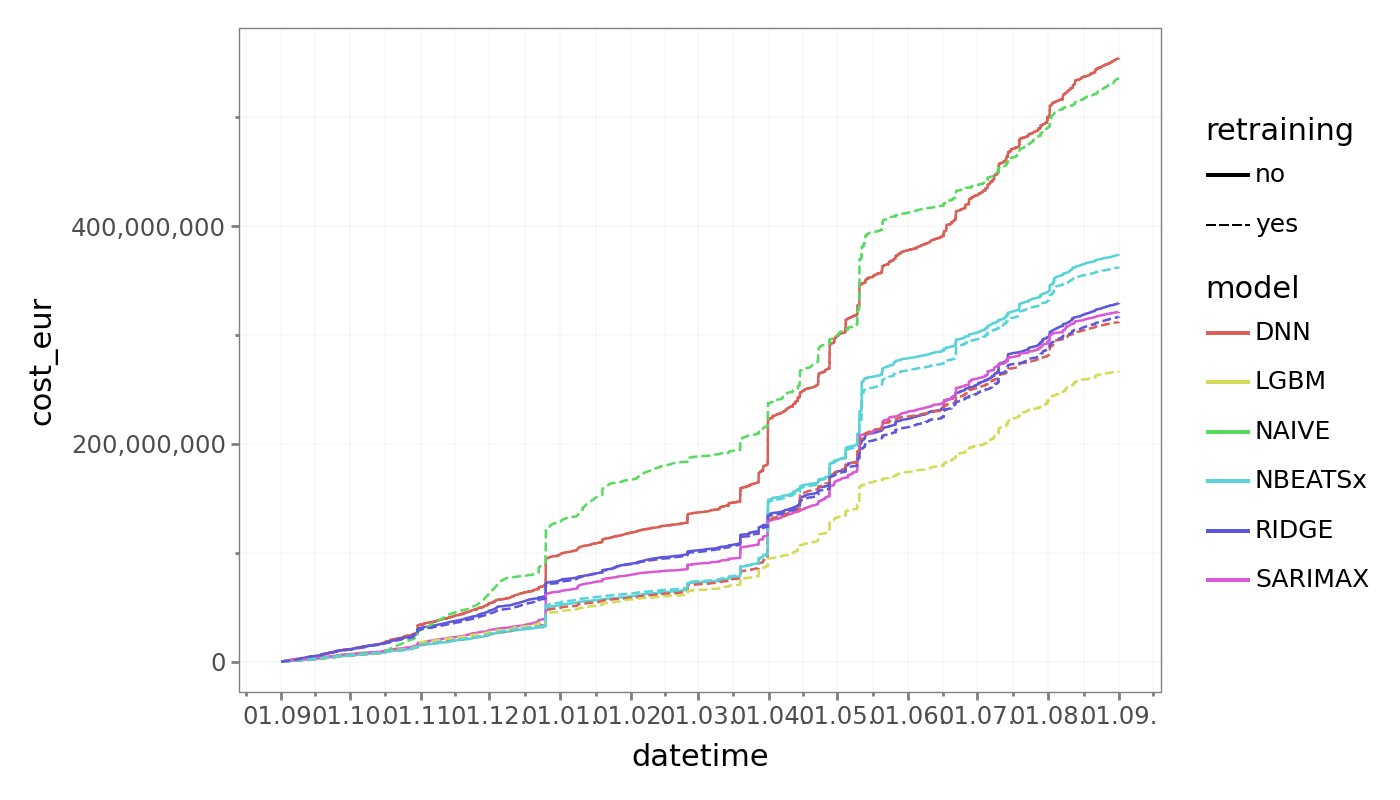

In [16]:
plot_width = 7
plot_height = 4

fig = (
    pn.ggplot(
        data=(
            bal_res_df
            # .filter(pl.col("model") != "NAIVE")
            .sort(["model", "retraining", "datetime"]).with_columns(
                pl.col("cost_eur").cum_sum().over(["model", "retraining"])
            )
        )
    )
    + pn.geom_step(
        mapping=pn.aes(
            x="datetime", y="cost_eur", colour="model", linetype="retraining"
        )
    )
    + pn.scale_x_datetime(date_breaks="1 month", date_labels="%d.%m.")
    + pn.scale_y_continuous(labels=comma_format())
    + theme_academic
    + pn.theme(figure_size=(plot_width, plot_height))
)

display(fig)

# fig.save(
#     filename="../1_figures/ridge_alpha_loss.pdf",
#     width=plot_width,
#     height=plot_height,
#     dpi=300,
# )

## Full year without holidays

In [17]:
import holidays

# Define the region (Canton of Berne) and the country (Switzerland)
country = "CH"
prov = "ZH"

# Create a list of the regional holidays for the canton of Berne
regional_holidays = holidays.CH(
    years=bal_res_df["datetime"].dt.year().unique().to_list(), prov=prov
)
regional_holidays

{datetime.date(2024, 1, 1): 'Neujahrestag', datetime.date(2024, 5, 9): 'Auffahrt', datetime.date(2024, 8, 1): 'Nationalfeiertag', datetime.date(2024, 12, 25): 'Weihnachten', datetime.date(2024, 1, 2): 'Berchtoldstag', datetime.date(2024, 3, 29): 'Karfreitag', datetime.date(2024, 4, 1): 'Ostermontag', datetime.date(2024, 5, 1): 'Tag der Arbeit', datetime.date(2024, 5, 20): 'Pfingstmontag', datetime.date(2024, 12, 26): 'Stephanstag', datetime.date(2023, 1, 1): 'Neujahrestag', datetime.date(2023, 5, 18): 'Auffahrt', datetime.date(2023, 8, 1): 'Nationalfeiertag', datetime.date(2023, 12, 25): 'Weihnachten', datetime.date(2023, 1, 2): 'Berchtoldstag', datetime.date(2023, 4, 7): 'Karfreitag', datetime.date(2023, 4, 10): 'Ostermontag', datetime.date(2023, 5, 1): 'Tag der Arbeit', datetime.date(2023, 5, 29): 'Pfingstmontag', datetime.date(2023, 12, 26): 'Stephanstag'}

In [18]:
holiday_df = pl.DataFrame(
    {
        "holiday_name": list(regional_holidays.values()),
        "holiday_date": list(regional_holidays.keys()),
    }
).sort("holiday_date")

holiday_manual_df = pl.DataFrame(
    {
        "holiday_name": [
            "Osterferienzeit",
            "Osterferienzeit",
            "Osterferienzeit",
            "Osterferienzeit",
            "Osterferienzeit",
            "Auffahrtferienzeit",
            "Auffahrtferienzeit",
            "Auffahrtferienzeit",
            "Auffahrtferienzeit",
            "Auffahrtferienzeit",
        ],
        "holiday_date": [
            # Osterferienzeit
            "2024-03-27",
            "2024-03-28",
            "2024-03-29",
            "2024-03-30",
            "2024-03-31",
            # Auffahrtferienzeit
            "2024-05-08",
            "2024-05-09",
            "2024-05-10",
            "2024-05-11",
            "2024-05-12",
        ],
    }
).with_columns(pl.col("holiday_date").str.to_date())

holiday_df = (
    pl.concat(
        [
            holiday_df,
            holiday_manual_df,
        ],
        how="vertical",
    )
    .sort("holiday_date")
    .unique("holiday_date")
)

holiday_df

holiday_name,holiday_date
str,date
"""Neujahrestag""",2023-01-01
"""Berchtoldstag""",2023-01-02
"""Karfreitag""",2023-04-07
"""Ostermontag""",2023-04-10
"""Tag der Arbeit""",2023-05-01
…,…
"""Auffahrtferienzeit""",2024-05-12
"""Pfingstmontag""",2024-05-20
"""Nationalfeiertag""",2024-08-01


In [19]:
# tmp = (
#     bal_res_df.filter(pl.col("model") != "NAIVE")
#     .filter(~pl.col("datetime").dt.date().is_in(holiday_df["holiday_date"]))
#     .with_columns(date=pl.col("datetime").dt.date())
#     .group_by(["model", "retraining", "date"])
#     .agg(cost_eur=pl.col("cost_eur").sum())
#     .sort("cost_eur", descending=True)
# )
# tmp

Summary table:

In [20]:
(
    bal_res_df.filter(~pl.col("datetime").dt.date().is_in(holiday_df["holiday_date"]))
    .group_by(["model", "retraining"])
    .agg(
        # total_costs_eur=pl.col("cost_eur").sum(),
        lower=pl.col("cost_eur_per_mwh").quantile(0.05),
        mean=pl.col("cost_eur_per_mwh").mean(),
        median=pl.col("cost_eur_per_mwh").quantile(0.5),
        upper=pl.col("cost_eur_per_mwh").quantile(0.95),
    )
    .sort("mean")
)

model,retraining,lower,mean,median,upper
str,str,f64,f64,f64,f64
"""DNN""","""no""",0.019356,1.080934,0.283121,2.881426
"""LGBM""","""yes""",0.017921,1.101822,0.26693,3.029565
"""DNN""","""yes""",0.020577,1.121978,0.295076,2.910097
"""SARIMAX""","""no""",0.020244,1.132273,0.321475,3.043743
"""NBEATSx""","""yes""",0.02156,1.153854,0.301597,3.034818
"""NBEATSx""","""no""",0.020891,1.180492,0.301206,3.277179
"""RIDGE""","""yes""",0.033754,1.385192,0.482141,3.575982
"""RIDGE""","""no""",0.037007,1.437881,0.495895,3.858831
"""NAIVE""","""yes""",0.044888,1.881034,0.675794,4.982824


Cumulative balance costs:

findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin

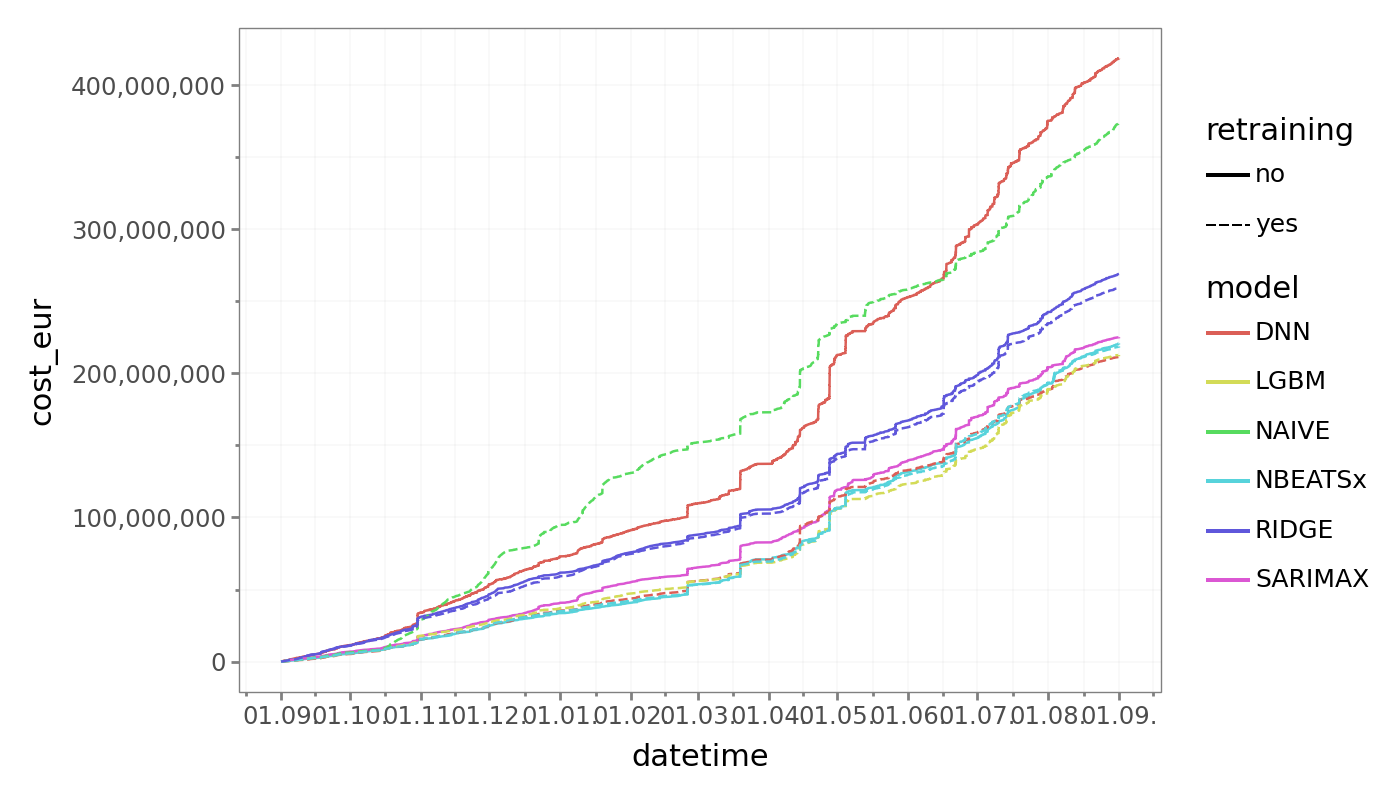

In [21]:
plot_width = 7
plot_height = 4

fig = (
    pn.ggplot(
        data=(
            bal_res_df.filter(
                ~pl.col("datetime").dt.date().is_in(holiday_df["holiday_date"])
            )
            .sort(["model", "retraining", "datetime"])
            .with_columns(pl.col("cost_eur").cum_sum().over(["model", "retraining"]))
        )
    )
    + pn.geom_step(
        mapping=pn.aes(
            x="datetime", y="cost_eur", colour="model", linetype="retraining"
        )
    )
    + pn.scale_x_datetime(date_breaks="1 month", date_labels="%d.%m.")
    + pn.scale_y_continuous(labels=comma_format())
    + theme_academic
    + pn.theme(figure_size=(plot_width, plot_height))
)

display(fig)

# fig.save(
#     filename="../1_figures/ridge_alpha_loss.pdf",
#     width=plot_width,
#     height=plot_height,
#     dpi=300,
# )